<a href="https://colab.research.google.com/github/AraiKensuke/AIiRPS/blob/master/Agglomerative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

------
[0 1 2 3 5 6 7 8 9]
[ 4 10 11]
------
[ 2  3  4  5  6  8  9 10 11]
[0 1 7]
------
[ 0  1  2  3  4  6  7 10 11]
[5 8 9]
------
[ 0  1  4  5  7  8  9 10 11]
[2 3 6]
------
[ 0  2  3  4  6  7  9 10 11]
[1 5 8]
------
[ 0  1  2  3  4  5  8  9 10]
[ 6  7 11]
------
[ 0  1  2  4  5  6  7  8 11]
[ 3  9 10]
------
[ 1  3  5  6  7  8  9 10 11]
[0 2 4]
coefficients when penalty for coefficients is small
[  -1.30657522 -228.82233096  525.56065802  316.17531973 -307.0136771
   89.32168772 -105.0813979   119.59798934  571.33087056   65.00731595]
coefficients when penalty for coefficients is large
[  0.          -0.         367.70185207   6.30190419   0.
   0.          -0.           0.         307.6057       0.        ]


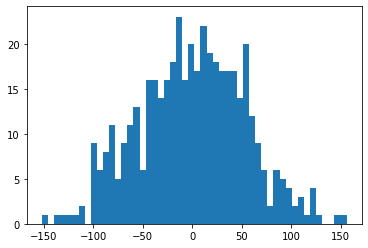

In [1]:
import numpy as np
import numpy as _N
import scipy.stats as _ss

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

def standardize(y):
    ys = y - _N.mean(y)
    ys /= _N.std(ys)
    return ys

def depickle(s):
    import pickle
    with open(s, "rb") as f:
        lm = pickle.load(f)
    return lm

def unskew(dat):
    sk = _N.empty(15)
    im = -1
    ms = _N.linspace(0.01, 1.1, 15)
    for m in ms:
        im += 1
        sk[im] = _ss.skew(_N.exp(dat / (m*_N.mean(dat))))
    min_im = _N.where(_N.abs(sk) == _N.min(_N.abs(sk)))[0][0]
    return _N.exp(dat / (ms[min_im]*_N.mean(dat)))

lm = depickle("predictAQ28dat/AQ28_vs_RPS_1.dmp")

features_cab = lm["features_cab"]
features_stat = lm["features_stat"]
cmp_againsts = features_cab + features_stat

iaf = -1
######  unskew and standardize the features to use.
for ca in cmp_againsts:
    exec("temp = lm[\"%(ca)s\"]" % {"ca" : ca})
    exec("%(ca)s = lm[\"%(ca)s\"]" % {"ca" : ca})    
    if ca[0:7] == "entropy":
        exec("temp = unskew(temp)" % {"ca" : ca})
    print(ca)
    exec("%(ca)s_s = standardize(temp)" % {"ca" : ca})

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

X_all_feats            = _N.empty((184, len(cmp_againsts)))

for af in cmp_againsts:
    iaf += 1
    exec("feat = %s_s" % af)    
    X_all_feats[:, iaf] = feat

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering()

model = model.fit(X_all_feats)

cl0  = _N.where(model.labels_ == 0)[0]
cl1  = _N.where(model.labels_ == 1)[0]

#for fact in ["soc_skils", "imag", "rout", "switch", "fact_pat"]:
for fact in ["AQ28scrs"]:
    scrs = lm[fact]
    print("%(1).1f   %(2).f" % {"1" : _N.mean(scrs[cl0]), "2" : _N.mean(scrs[cl1])})
    
# plt.title("Hierarchical Clustering Dendrogram")
# # plot the top three levels of the dendrogram
# plot_dendrogram(model, truncate_mode="level", p=3)
# plt.xlabel("Number of points in node (or index of point if no parenthesis).")
# plt.show()
